In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Example-Fire Alarm').getOrCreate()


In [2]:
#import functions and datatypes
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
file_path = 'C:/Users/Aayush/Downloads/sf-fire-calls.csv'
fire_df = spark.read.csv(file_path, header=True, inferSchema = True)
fire_df.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: integer (nullable = true)
 |-- ALSUnit: boolean (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: integer (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 

In [4]:
clean_df = fire_df.select('CallType','CallDate','City','Zipcode','Neighborhood','Delay')
clean_df.printSchema()

root
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Delay: double (nullable = true)



In [5]:
clean_df=clean_df.withColumn('Date',to_date(col('CallDate'),'MM/dd/yyyy'))
clean_df = clean_df.drop('CallDate')

In [6]:
clean_df = clean_df.withColumn('Year',year(col('Date')))\
    .withColumn('Month',month(col('Date')))\
    .withColumn('Week',weekofyear(col('Date')))

clean_df.show()

+----------------+----+-------+--------------------+---------+----------+----+-----+----+
|        CallType|City|Zipcode|        Neighborhood|    Delay|      Date|Year|Month|Week|
+----------------+----+-------+--------------------+---------+----------+----+-----+----+
|  Structure Fire|  SF|  94109|     Pacific Heights|     2.95|2002-01-11|2002|    1|   2|
|Medical Incident|  SF|  94124|Bayview Hunters P...|      4.7|2002-01-11|2002|    1|   2|
|Medical Incident|  SF|  94102|          Tenderloin|2.4333334|2002-01-11|2002|    1|   2|
|    Vehicle Fire|  SF|  94110|      Bernal Heights|      1.5|2002-01-11|2002|    1|   2|
|          Alarms|  SF|  94109|    Western Addition|3.4833333|2002-01-11|2002|    1|   2|
|  Structure Fire|  SF|  94105|Financial Distric...|     1.75|2002-01-11|2002|    1|   2|
|          Alarms|  SF|  94112|Oceanview/Merced/...|2.7166667|2002-01-11|2002|    1|   2|
|          Alarms|  SF|  94102|          Tenderloin|1.7833333|2002-01-11|2002|    1|   2|
|Medical I

In [7]:
#Add user defined function to create season
from pyspark.sql.types import *
def mapSeason(data):
    if 2<data<6:
        return 'Spring'
    elif 5<data<9:
        return 'Summer'
    elif 8<data<12:
        return 'Autumn'
    else:
        return 'Winter'
    
seasons_udf = udf(mapSeason,StringType())
clean_df = clean_df.withColumn('Season',seasons_udf(col('Month')))
clean_df.show()

+----------------+----+-------+--------------------+---------+----------+----+-----+----+------+
|        CallType|City|Zipcode|        Neighborhood|    Delay|      Date|Year|Month|Week|Season|
+----------------+----+-------+--------------------+---------+----------+----+-----+----+------+
|  Structure Fire|  SF|  94109|     Pacific Heights|     2.95|2002-01-11|2002|    1|   2|Winter|
|Medical Incident|  SF|  94124|Bayview Hunters P...|      4.7|2002-01-11|2002|    1|   2|Winter|
|Medical Incident|  SF|  94102|          Tenderloin|2.4333334|2002-01-11|2002|    1|   2|Winter|
|    Vehicle Fire|  SF|  94110|      Bernal Heights|      1.5|2002-01-11|2002|    1|   2|Winter|
|          Alarms|  SF|  94109|    Western Addition|3.4833333|2002-01-11|2002|    1|   2|Winter|
|  Structure Fire|  SF|  94105|Financial Distric...|     1.75|2002-01-11|2002|    1|   2|Winter|
|          Alarms|  SF|  94112|Oceanview/Merced/...|2.7166667|2002-01-11|2002|    1|   2|Winter|
|          Alarms|  SF|  94102

In [8]:
#1. Get yearly count of fire calls
clean_df.select('Year')\
    .groupBy('Year')\
    .count()\
    .orderBy('Year').show()

+----+-----+
|Year|count|
+----+-----+
|2000| 5459|
|2001| 7713|
|2002| 8090|
|2003| 8499|
|2004| 8283|
|2005| 8282|
|2006| 8174|
|2007| 8255|
|2008| 8869|
|2009| 8789|
|2010| 9341|
|2011| 9735|
|2012| 9674|
|2013|10020|
|2014|10775|
|2015|11458|
|2016|11609|
|2017|12135|
|2018|10136|
+----+-----+



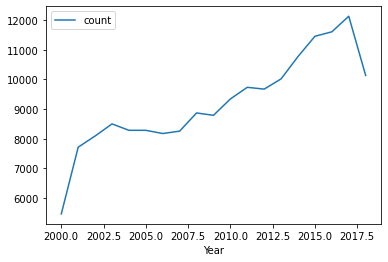

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
pandas_df = clean_df.select('Year')\
    .groupBy('Year')\
    .count()\
    .orderBy('Year').toPandas()

pandas_df.plot.line(x='Year',y='count')
plt.show()

In [10]:
#2. What were all the different types of fire calls in 2018?
clean_df.select('CallType')\
    .where(col('Year')==2018)\
    .distinct().show() 

+--------------------+
|            CallType|
+--------------------+
|Elevator / Escala...|
|              Alarms|
|Odor (Strange / U...|
|Citizen Assist / ...|
|              HazMat|
|           Explosion|
|        Vehicle Fire|
|  Suspicious Package|
|               Other|
|        Outside Fire|
|   Traffic Collision|
|       Assist Police|
|Gas Leak (Natural...|
|        Water Rescue|
|   Electrical Hazard|
|      Structure Fire|
|    Medical Incident|
|          Fuel Spill|
|Smoke Investigati...|
|Train / Rail Inci...|
+--------------------+



In [11]:
#3. Which week in the year in 2018 had the most fire calls?
clean_df.select('Week')\
    .where(col('Year')==2018)\
    .groupBy('Week')\
    .count()\
    .orderBy('count',ascending=False).collect()[0][0]  
   # .orderBy('count',ascending=False).show(1) # one approach

22

In [12]:
#4. Get monthly count of fire calls based on year
clean_df.select(col('Year'),col('Month'))\
    .groupBy('Year','Month')\
    .count()\
    .orderBy('Year','Month').collect()

[Row(Year=2000, Month=4, count=335),
 Row(Year=2000, Month=5, count=680),
 Row(Year=2000, Month=6, count=585),
 Row(Year=2000, Month=7, count=668),
 Row(Year=2000, Month=8, count=678),
 Row(Year=2000, Month=9, count=655),
 Row(Year=2000, Month=10, count=620),
 Row(Year=2000, Month=11, count=595),
 Row(Year=2000, Month=12, count=643),
 Row(Year=2001, Month=1, count=622),
 Row(Year=2001, Month=2, count=613),
 Row(Year=2001, Month=3, count=692),
 Row(Year=2001, Month=4, count=636),
 Row(Year=2001, Month=5, count=682),
 Row(Year=2001, Month=6, count=672),
 Row(Year=2001, Month=7, count=646),
 Row(Year=2001, Month=8, count=660),
 Row(Year=2001, Month=9, count=577),
 Row(Year=2001, Month=10, count=673),
 Row(Year=2001, Month=11, count=619),
 Row(Year=2001, Month=12, count=621),
 Row(Year=2002, Month=1, count=726),
 Row(Year=2002, Month=2, count=681),
 Row(Year=2002, Month=3, count=665),
 Row(Year=2002, Month=4, count=630),
 Row(Year=2002, Month=5, count=621),
 Row(Year=2002, Month=6, count=6

In [13]:
#5. Give monthly report of fire call types for selected year
clean_df.select(col('Year'),col('Month'),col('CallType'))\
    .where(col('Year')==2018)\
    .groupBy('Year','Month','CallType')\
    .count()\
    .orderBy('Month','CallType').collect()

[Row(Year=2018, Month=1, CallType='Alarms', count=122),
 Row(Year=2018, Month=1, CallType='Citizen Assist / Service Call', count=15),
 Row(Year=2018, Month=1, CallType='Electrical Hazard', count=3),
 Row(Year=2018, Month=1, CallType='Elevator / Escalator Rescue', count=3),
 Row(Year=2018, Month=1, CallType='Fuel Spill', count=1),
 Row(Year=2018, Month=1, CallType='Gas Leak (Natural and LP Gases)', count=5),
 Row(Year=2018, Month=1, CallType='HazMat', count=1),
 Row(Year=2018, Month=1, CallType='Medical Incident', count=692),
 Row(Year=2018, Month=1, CallType='Odor (Strange / Unknown)', count=2),
 Row(Year=2018, Month=1, CallType='Other', count=3),
 Row(Year=2018, Month=1, CallType='Outside Fire', count=14),
 Row(Year=2018, Month=1, CallType='Smoke Investigation (Outside)', count=3),
 Row(Year=2018, Month=1, CallType='Structure Fire', count=91),
 Row(Year=2018, Month=1, CallType='Traffic Collision', count=42),
 Row(Year=2018, Month=1, CallType='Train / Rail Incident', count=2),
 Row(Yea

In [14]:
#6. Give top five fire call types for every season of selected year (seasons are like Spring, summer, fall winter etc).
rank_df = clean_df.select(col('Year'),col('Season'),col('CallType'))\
    .where(col('Year')==2018)\
    .groupBy('Year','Season','CallType')\
    .count()\
    .orderBy('Year','Season','count', ascending = False)

from pyspark.sql.window import Window
windowPartition = Window.partitionBy('Year','Season').orderBy("Year","Season",desc("count"))

rank_df =  rank_df.withColumn('Rank',row_number().over(windowPartition))

rank_df.select(col('Year'),col('Season'),col('CallType'),col('count'))\
    .where(col('Rank')<6).show()

+----+------+-----------------+-----+
|Year|Season|         CallType|count|
+----+------+-----------------+-----+
|2018|Summer| Medical Incident| 2053|
|2018|Summer|           Alarms|  336|
|2018|Summer|   Structure Fire|  262|
|2018|Summer|Traffic Collision|  121|
|2018|Summer|     Outside Fire|   61|
|2018|Autumn| Medical Incident| 1514|
|2018|Autumn|           Alarms|  251|
|2018|Autumn|   Structure Fire|  201|
|2018|Autumn|Traffic Collision|  100|
|2018|Autumn|     Outside Fire|   39|
|2018|Winter| Medical Incident| 1327|
|2018|Winter|           Alarms|  224|
|2018|Winter|   Structure Fire|  182|
|2018|Winter|Traffic Collision|   79|
|2018|Winter|     Outside Fire|   28|
|2018|Spring| Medical Incident| 2110|
|2018|Spring|           Alarms|  333|
|2018|Spring|   Structure Fire|  261|
|2018|Spring|Traffic Collision|  133|
|2018|Spring|            Other|   36|
+----+------+-----------------+-----+



In [15]:
#7. Whether fire type calls are seasonal?
fire_call = clean_df.select(col('Year'),col('Season'),col('CallType'))\
    .groupBy('Year','Season','CallType')\
    .count()\
    .orderBy('Year','Season',desc('count')).show()

#plot needed


+----+------+--------------------+-----+
|Year|Season|            CallType|count|
+----+------+--------------------+-----+
|2000|Autumn|    Medical Incident| 1163|
|2000|Autumn|      Structure Fire|  358|
|2000|Autumn|              Alarms|  203|
|2000|Autumn|Citizen Assist / ...|   41|
|2000|Autumn|               Other|   35|
|2000|Autumn|        Outside Fire|   19|
|2000|Autumn|        Vehicle Fire|   11|
|2000|Autumn|Odor (Strange / U...|    8|
|2000|Autumn|          Fuel Spill|    6|
|2000|Autumn|Gas Leak (Natural...|    6|
|2000|Autumn|Elevator / Escala...|    5|
|2000|Autumn|Smoke Investigati...|    5|
|2000|Autumn|        Water Rescue|    4|
|2000|Autumn|           Oil Spill|    2|
|2000|Autumn|   Electrical Hazard|    2|
|2000|Autumn|  Aircraft Emergency|    1|
|2000|Autumn|Industrial Accidents|    1|
|2000|Spring|    Medical Incident|  643|
|2000|Spring|      Structure Fire|  170|
|2000|Spring|              Alarms|  120|
+----+------+--------------------+-----+
only showing top

In [16]:
#8. What months within the year 2018 saw the highest number of fire calls?
clean_df.select(col('Year'),col('Month'))\
    .where(col('Year')==2018)\
    .groupBy('Year','Month')\
    .count()\
    .orderBy('count',ascending=False).show(1)

+----+-----+-----+
|Year|Month|count|
+----+-----+-----+
|2018|   10| 1068|
+----+-----+-----+
only showing top 1 row



In [17]:
#9. Find which type of fire call is major calltype in each year
rank_df2 = clean_df.select(col('Year'),col('CallType'))\
    .groupBy('Year','CallType')\
    .count()\
    .orderBy('Year',desc('count'))
    
windowPartition = Window.partitionBy('Year').orderBy("Year",desc("count"))

rank_df2 =  rank_df2.withColumn('Rank',row_number().over(windowPartition))

rank_df2.select('Year','CallType','count')\
    .where(col('Rank')<2)\
    .orderBy('Year').show()


+----+----------------+-----+
|Year|        CallType|count|
+----+----------------+-----+
|2000|Medical Incident| 3408|
|2001|Medical Incident| 4653|
|2002|Medical Incident| 5046|
|2003|Medical Incident| 5056|
|2004|Medical Incident| 5137|
|2005|Medical Incident| 5084|
|2006|Medical Incident| 5027|
|2007|Medical Incident| 5114|
|2008|Medical Incident| 5692|
|2009|Medical Incident| 5671|
|2010|Medical Incident| 6186|
|2011|Medical Incident| 6413|
|2012|Medical Incident| 6296|
|2013|Medical Incident| 6690|
|2014|Medical Incident| 7176|
|2015|Medical Incident| 7812|
|2016|Medical Incident| 7999|
|2017|Medical Incident| 8330|
|2018|Medical Incident| 7004|
+----+----------------+-----+



In [18]:
#10.Find out average delay in response for each call type
clean_df.select(col('CallType'),col('Delay'))\
    .groupBy('CallType')\
    .agg({'Delay': 'avg'}).collect()

[Row(CallType='Elevator / Escalator Rescue', avg(Delay)=4.3378219334878585),
 Row(CallType='Marine Fire', avg(Delay)=6.928571314285715),
 Row(CallType='Aircraft Emergency', avg(Delay)=3.7731481499999995),
 Row(CallType='Confined Space / Structure Collapse', avg(Delay)=6.915384576923078),
 Row(CallType='Administrative', avg(Delay)=12.261111333333332),
 Row(CallType='Alarms', avg(Delay)=3.5427290545084023),
 Row(CallType='Odor (Strange / Unknown)', avg(Delay)=4.947959182),
 Row(CallType='Citizen Assist / Service Call', avg(Delay)=5.473342576604596),
 Row(CallType='HazMat', avg(Delay)=7.527016126612902),
 Row(CallType='Watercraft in Distress', avg(Delay)=6.886904817857143),
 Row(CallType='Explosion', avg(Delay)=4.110674168539325),
 Row(CallType='Oil Spill', avg(Delay)=4.977777761904761),
 Row(CallType='Vehicle Fire', avg(Delay)=3.903922713407494),
 Row(CallType='Suspicious Package', avg(Delay)=6.5766667199999995),
 Row(CallType='Extrication / Entrapped (Machinery, Vehicle)', avg(Delay)=4.

In [19]:
#11. Find which calltype has maximum average delay time.
clean_df.select(col('CallType'),col('Delay'))\
    .groupBy('CallType')\
    .agg({'Delay': 'avg'})\
    .orderBy(desc('avg(Delay)')).show(1)

+--------------------+------------------+
|            CallType|        avg(Delay)|
+--------------------+------------------+
|Mutual Aid / Assi...|38.416666311111115|
+--------------------+------------------+
only showing top 1 row



In [20]:
#12. Which neighborhood in San Francisco generated the most fire calls in 2018
clean_df.select(col('city'),col('Neighborhood'))\
    .where(col('city')=='San Francisco')\
    .where(col('Year')==2018)\
    .groupBy('city','Neighborhood')\
    .count()\
    .orderBy(desc('count'))\
    .show(1)

+-------------+------------+-----+
|         city|Neighborhood|count|
+-------------+------------+-----+
|San Francisco|  Tenderloin| 1393|
+-------------+------------+-----+
only showing top 1 row



In [29]:
#13. Which neighborhoods had the worst response times to fire calls in 2018?
clean_df.select(col('Neighborhood'),col('Delay'))\
    .where(col('Year')==2018)\
    .groupBy(col('Neighborhood'))\
    .agg({'Delay': 'max'})\
    .orderBy(desc('max(Delay)'))\
    .show(1)

+------------+----------+
|Neighborhood|max(Delay)|
+------------+----------+
|   Chinatown| 491.26666|
+------------+----------+
only showing top 1 row



In [ ]:
#14. Find out calltype whose average response delay time is maximum, increases, decreases or has no relation over years.
#exploratory analysis

In [45]:
#15. For each year find out which city has more calltypes
call_typ = clean_df.select(col('Year'),col('City'),col('CallType'))\
    .groupBy(col('Year'),col('City'),col('CallType'))\
    .count()\
    .orderBy(asc('Year'),asc('City'),desc('count')) #count based on fire calls for each city and year for different call types


call_typ2 = call_typ.select(col('Year'),col('City'))\
    .groupBy(col('Year'),col('City'))\
    .count()\
    .orderBy(asc('Year'),desc('count')) # year and citywise fire call types 

windowPartition = Window.partitionBy('Year').orderBy("Year",desc("count"))

call_typ2 =  call_typ2.withColumn('Rank',row_number().over(windowPartition))

call_typ2.select('Year','City','count')\
    .where(col('Rank')<2)\
    .orderBy('Year','City').show()

+----+-------------+-----+
|Year|         City|count|
+----+-------------+-----+
|2000|           SF|   18|
|2001|           SF|   20|
|2002|           SF|   20|
|2003|           SF|   24|
|2004|           SF|   23|
|2005|           SF|   26|
|2006|           SF|   24|
|2007|           SF|   26|
|2008|           SF|   23|
|2009|           SF|   22|
|2010|           SF|   23|
|2011|           SF|   25|
|2012|           SF|   25|
|2013|           SF|   24|
|2014|San Francisco|   21|
|2015|San Francisco|   24|
|2016|San Francisco|   24|
|2017|San Francisco|   26|
|2018|San Francisco|   20|
+----+-------------+-----+



In [46]:
#16. For every year find count of calltypes ------ for 5 cities which has more calls.
call_typ = clean_df.select(col('Year'),col('City'),col('CallType'))\
    .groupBy(col('Year'),col('City'),col('CallType'))\
    .count()\
    .orderBy(asc('Year'),asc('City'),desc('count'))



+----+----+--------------------+-----+
|Year|City|            CallType|count|
+----+----+--------------------+-----+
|2000|  DC|    Medical Incident|    1|
|2000|  DC|               Other|    1|
|2000|  FM|      Structure Fire|    1|
|2000|  HP|      Structure Fire|    2|
|2000|  HP|    Medical Incident|    1|
|2000|  PR|        Water Rescue|    1|
|2000|  PR|        Vehicle Fire|    1|
|2000|  SF|    Medical Incident| 3399|
|2000|  SF|      Structure Fire| 1002|
|2000|  SF|              Alarms|  620|
|2000|  SF|Citizen Assist / ...|  124|
|2000|  SF|               Other|   99|
|2000|  SF|        Outside Fire|   67|
|2000|  SF|        Vehicle Fire|   30|
|2000|  SF|Odor (Strange / U...|   19|
|2000|  SF|Elevator / Escala...|   15|
|2000|  SF|Smoke Investigati...|   12|
|2000|  SF|          Fuel Spill|   12|
|2000|  SF|Gas Leak (Natural...|   11|
|2000|  SF|        Water Rescue|    7|
+----+----+--------------------+-----+
only showing top 20 rows



In [ ]:
#17. Is there a correlation between neighborhood, zip code, and number of fire calls?